In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import itertools
from collections import Counter
import itertools as it
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE

import pickle

In [2]:
# Set random seed for reproducibility
randomSeed = 10

In [3]:
# Load time series features data: y=1 (churned), y=0 (active)
predictTimeStep = 2
fillnaTimeLag = 7
filename = 'features_perTerm_fillNA1_timeLag' + str(fillnaTimeLag) + '_timestep'+ str(predictTimeStep) + 'T1'
dfFeaturesTS = pd.read_csv('dataProcessed/' + filename + '.csv', index_col = 0)
idFeatures = dfFeaturesTS[['userid','termid']].drop_duplicates() 
userID = idFeatures['userid'].unique()
termID = idFeatures['termid'].unique()

# Load average activity (across all terms) data
dfFeatures = pd.read_csv('dataProcessed/data_user_activity_summary.csv', index_col = 0)
dfFeatures = dfFeatures[dfFeatures['userid'].isin(userID)] # select users that are included in the time series data
dfFeatures.loc[dfFeatures['status']=='active','status'] = 0
dfFeatures.loc[dfFeatures['status']=='cancel','status'] = 1
#print('Total number of data points:', len(dfFeatures))
#print('Number of active (y=0) terms:', len(dfFeatures.loc[dfFeatures['status']==0]))
#print('Number of churned (y=1) terms:', len(dfFeatures.loc[dfFeatures['status']==1]))
print('Percentage of churned data:', len(dfFeatures.loc[dfFeatures['status']==1])/len(dfFeatures)*100)


# Create feature and target(Y) matrices
rangeCol = np.arange(2,len(dfFeatures.columns))
indState = 6 # exclude state (stateID is already included)
indCol = rangeCol[rangeCol != indState]
colFeatures = dfFeatures.columns[indCol]
#print('Features:', colFeatures)
#print('Number of features:', len(colFeatures))

X = dfFeatures[colFeatures]
Y = dfFeatures['status'].astype(int)


Percentage of churned data: 27.464788732394368


In [4]:
# Partition data into train(feature) and test sets
nFoldsCV = 3 # total number of cross-validation folds
featureX, testX, featureY, testY = train_test_split(X, Y,
                                                    test_size=1/nFoldsCV, 
                                                    stratify=Y, 
                                                    random_state=randomSeed)

In [5]:
# Run parameter tuning
nTrees = np.arange(2, 500, 5)
minSamplesLeaf = np.arange(1,200,5)

# split training data further to train & validation folds
skf = StratifiedKFold(n_splits = nFoldsCV-1, random_state=randomSeed) 

# create a dataframe to save validation performance metrics
colnames = ['num_fold','n_estimators','min_samples_leaf','recall','auc_roc','auc_pr']
dfGridSearch = pd.DataFrame(columns = colnames)

# run cross-validation
counterFold = -1
for indexTrain, indexVal in skf.split(featureX, featureY):
    counterFold += 1
    
    # split datasets into training and validation
    trainX = featureX.iloc[indexTrain]
    trainY = featureY.iloc[indexTrain]
    valX = featureX.iloc[indexVal]
    valY = featureY.iloc[indexVal]
    print('Original dataset shape {}'.format(Counter(trainY)))
    
    # SMOTE: Oversample training data [this applies to the training dataset only]
    sm = SMOTE(random_state = randomSeed, ratio = 1.0)
    trainX_res, trainY_res = sm.fit_sample(trainX, trainY)
    print('Resampled dataset shape {}'.format(Counter(trainY_res)))
    
    # Due to SMOTE, need to run manual grid search
    for nTree in nTrees:
        for minSample in minSamplesLeaf:
            clf = RandomForestClassifier(n_estimators = nTree,
                                         min_samples_leaf = minSample,
                                         n_jobs = -1,
                                         random_state=randomSeed)
            clf.fit(trainX_res, trainY_res)
            
            # test on validation set: auc & recall are evaluation metrics of interest
            hard_pred = clf.predict(valX) # binary classification: based on 0.5 threshold
            soft_pred = clf.predict_proba(valX) # probability
            
            auc_roc = roc_auc_score(valY,soft_pred[:,1]) # AUC of ROC curve
            
            recall = recall_score(valY,hard_pred) # recall score (based on 0.5 threshold)
            precision_curve, recall_curve, thresholds = precision_recall_curve(valY,soft_pred[:,1]) # precision & recall
            auc_pr = auc(recall_curve, precision_curve) # auc of precision-recall curve
            
            # append results
            row = pd.Series({'num_fold': counterFold,
                             'n_estimators': nTree, 
                             'min_samples_leaf': minSample,
                             'recall': recall,
                             'auc_roc': auc_roc,
                             'auc_pr': auc_pr})
            
            dfGridSearch = dfGridSearch.append(row,ignore_index = True)
            
            
dfGridSearch.tail()    


Original dataset shape Counter({0: 68, 1: 26})
Resampled dataset shape Counter({0: 68, 1: 68})
Original dataset shape Counter({0: 69, 1: 26})
Resampled dataset shape Counter({1: 69, 0: 69})


,num_fold,n_estimators,min_samples_leaf,recall,auc_roc,auc_pr
7995,1.0,497.0,176.0,1.0,0.5,0.638298
7996,1.0,497.0,181.0,1.0,0.5,0.638298
7997,1.0,497.0,186.0,1.0,0.5,0.638298
7998,1.0,497.0,191.0,1.0,0.5,0.638298
7999,1.0,497.0,196.0,1.0,0.5,0.638298


In [6]:
# Extract the best model parameters
summary = dfGridSearch.groupby(['n_estimators','min_samples_leaf']).mean()

maxRecall = summary.loc[summary['recall'] == summary['recall'].max()]
param_maxRecall = maxRecall.index.values
#print('max recall:', summary['recall'].max())
#print('max recall parameters:',param_maxRecall)

maxAUC_ROC = summary.loc[summary['auc_roc'] == summary['auc_roc'].max()]
param_maxAUC_ROC = maxAUC_ROC.index.values
print('max AUC of ROC curve:', summary['auc_roc'].max())
print('max AUC of ROC parameters:',param_maxAUC_ROC)

maxAUC_PR = summary.loc[summary['auc_pr'] == summary['auc_pr'].max()]
param_maxAUC_PR = maxAUC_PR.index.values
print('max AUC of P-R curve:', summary['auc_pr'].max())
print('max AUC of P-R parameters:',param_maxAUC_PR)


max AUC of ROC curve: 0.991417469998
max AUC of ROC parameters: [(62.0, 1.0)]
max AUC of P-R curve: 0.979656354322
max AUC of P-R parameters: [(52.0, 1.0)]


In [5]:
# Using the best parameters, train the model again
# SMOTE: Oversample training data [this applies to the training dataset only]
sm = SMOTE(random_state = randomSeed, ratio = 1.0)
featureX_res, featureY_res = sm.fit_sample(featureX, featureY)
print('Original dataset shape {}'.format(Counter(featureY)))
print('Resampled dataset shape {}'.format(Counter(featureY_res)))

# Train model
param = param_maxAUC_PR[0] # use parameters from maximum AUC of precision-recall curve
model = RandomForestClassifier(n_estimators = int(param[0]),
                               min_samples_leaf = int(param[1]),
                               n_jobs = -1,
                               random_state=randomSeed)
model.fit(featureX_res, featureY_res)

Original dataset shape Counter({0: 137, 1: 52})
Resampled dataset shape Counter({1: 137, 0: 137})


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=52, n_jobs=-1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [6]:
# Test model
predY = model.predict(testX) # binary classification: based on 0.5 threshold
probY = model.predict_proba(testX) # probability

print(classification_report(testY, predY))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98        69
          1       1.00      0.88      0.94        26

avg / total       0.97      0.97      0.97        95



Accuracy: 0.968421052631579
ROC Curve:


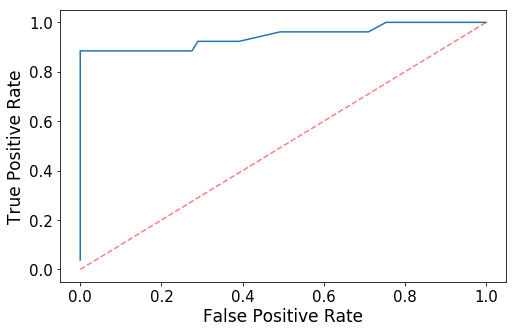

AUC: 0.943979933110368


In [7]:
# ROC Curve
accuracy = accuracy_score(testY,predY)
fpr,tpr,thresh = roc_curve(testY,probY[:,1])
auc = roc_auc_score(testY,probY[:,1])

print("Accuracy: {}".format(accuracy))
print("ROC Curve:")
plt.figure(figsize=(8,5))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],"r--",alpha=.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('False Positive Rate',fontsize=17)
plt.ylabel('True Positive Rate',fontsize=17)
plt.show()
print("AUC: {}".format(auc))

Normalized confusion matrix
[[ 1.          0.        ]
 [ 0.11538462  0.88461538]]


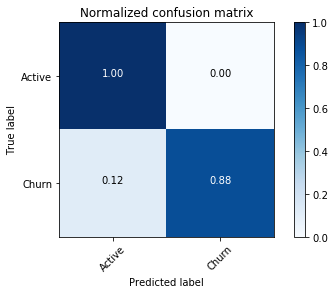

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Confusion matrix
cnf_matrix = confusion_matrix(testY, predY)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Active','Churn'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()


Precision-Recall Curve:


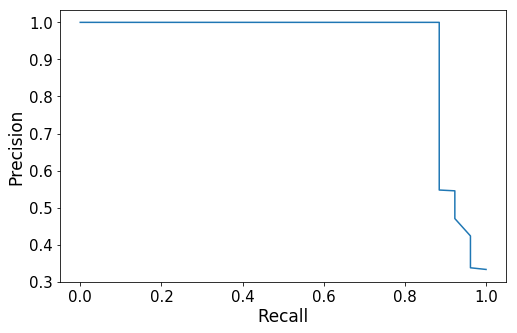

In [10]:
# Precision & Recall
precision, recall, thresholds = precision_recall_curve(testY,probY[:,1])

print("Precision-Recall Curve:")
plt.figure(figsize=(8,5))
plt.plot(recall,precision)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Recall',fontsize=17)
plt.ylabel('Precision',fontsize=17)
plt.show()


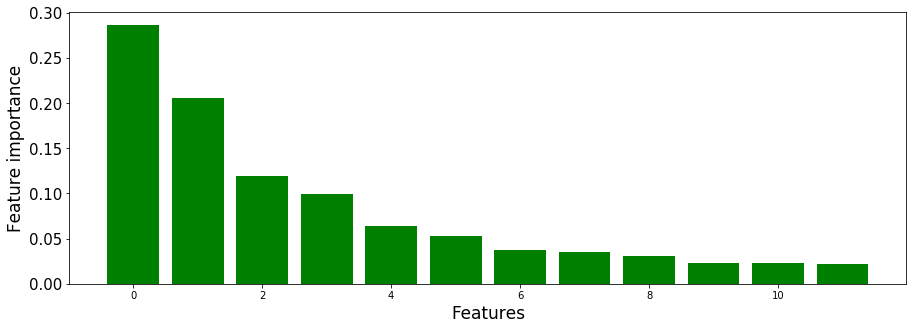

In [11]:
# Feature importance
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
#print(importances[indices])
#print(colFeatures[indices])

plt.figure(figsize=(15,5))
plt.bar(range(len(colFeatures)), importances[indices], color='g', align="center")
#plt.xticks(range(len(colFeatures)), colFeatures[indices])
plt.yticks(fontsize=15)
plt.ylabel('Feature importance',fontsize=17)
plt.xlabel('Features',fontsize=17)
plt.show()

In [12]:
# SAVE MODEL
filename = 'random_forest_SMOTE_allTerms_randomseed10_nEst'+ str(param[0]) + 'minSL' + str(param[1])
pickle.dump(model, open('pickleModels/'+ filename + '.sav', 'wb'))